# Boosting Homework 
***
                                        Name: Prathyusha Gayam 
***

This assignment is due on Moodle by **5pm on Friday April 13th**. Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. Your solutions to analysis questions should be done in Markdown directly below the associated question.  Remember that you are encouraged to discuss the problems with your instructors and classmates, but **you must write all code and solutions on your own**.  For a refresher on the course **Collaboration Policy** click [here](https://github.com/chrisketelsen/CSCI5622-Machine-Learning/blob/master/resources/syllabus.md#collaboration-policy)



## Overview 
***



In this homework you'll implement the AdaBoost classification framework to do handwritten digit recognition. Your implementation should be based on the description of AdaBoost given in the lecture slides.

<br>

![digits](mnist.png "mnist data")


<br>

Here are the rules: 

- Do **NOT** use sklearn's implementation of Adaboost.  You may however use sklearn's implementation of decisions trees. 
- Do **NOT** load or use any Python packages that are not available in Anaconda 3.6. 
- Some problems with code may be autograded.  If we provide a function or class API **do not** change it.
- Do not change the location of the data or data directory.  Use only relative paths to access the data. 

In [1]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone 
import matplotlib.pylab as plt
import math
%matplotlib inline 

### [5 points] Problem 1
***

Since we'll be working with binary classifiers, we'll look at the subset of the MNIST data pertaining to handwritten three's and eights. Note that we'll also be using a lower-res version of the MNIST data used in the KNN homework. The class below will load, parse, and store the subset of the. Load the data and then report: 

- The number of examples in the training set 
- The number of examples in the validation set 
- The number of pixels in each image. 

In [2]:
class ThreesAndEights:
    """
    Class to store MNIST data
    """

    def __init__(self, location):

        import pickle, gzip

        # Load the dataset
        f = gzip.open(location, 'rb')

        # Split the data set 
        X_train, y_train, X_valid, y_valid = pickle.load(f)

        # Extract only 3's and 8's for training set 
        self.X_train = X_train[np.logical_or( y_train==3, y_train == 8), :]
        self.y_train = y_train[np.logical_or( y_train==3, y_train == 8)]
        self.y_train = np.array([1 if y == 8 else -1 for y in self.y_train])
        
        # Shuffle the training data 
        shuff = np.arange(self.X_train.shape[0])
        np.random.shuffle(shuff)
        self.X_train = self.X_train[shuff,:]
        self.y_train = self.y_train[shuff]
        
        # Extract only 3's and 8's for validation set 
        self.X_valid = X_valid[np.logical_or( y_valid==3, y_valid == 8), :]
        self.y_valid = y_valid[np.logical_or( y_valid==3, y_valid == 8)]
        self.y_valid = np.array([1 if y == 8 else -1 for y in self.y_valid])
        
        f.close()

In [3]:
data = ThreesAndEights("../data/mnist21x21_3789.pklz")

In [4]:
print("number of training examples", len(data.y_train))
print("number of validation examples", len(data.y_valid))
print("number of pixles in each image", len(data.X_train[0]))

number of training examples 2000
number of validation examples 500
number of pixles in each image 441


### [20 points] Problem 2: Implementing AdaBoost  
***

We've given you a skeleton of the class `AdaBoost` below which will train a classifier based on boosted shallow decision trees as implemented by sklearn. Take a look at the class skeleton first so that you understand the underlying organization and data structures that we'll be using.  

In [5]:
class AdaBoost:
    def __init__(self, n_learners=20, base=DecisionTreeClassifier(max_depth=1), random_state=1234):
        """
        Create a new adaboost classifier.
        
        Args:
            N (int, optional): Number of weak learners in classifier.
            base (BaseEstimator, optional): Your general weak learner 
            random_state (int, optional): set random generator.  needed for unit testing. 

        Attributes:
            base (estimator): Your general weak learner 
            n_learners (int): Number of weak learners in classifier.
            alpha (ndarray): Coefficients on weak learners. 
            learners (list): List of weak learner instances. 
        """
        
        np.random.seed(random_state)
        
        self.n_learners = n_learners 
        self.base = base
        self.alpha = np.zeros(self.n_learners)
        self.learners = []
        
    def fit(self, X_train, y_train):
        """
        Train AdaBoost classifier on data. Sets alphas and learners. 
        
        Args:
            X_train (ndarray): [n_samples x n_features] ndarray of training data   
            y_train (ndarray): [n_samples] ndarray of data 
        """
        
        # TODO 

        # Note: You can create and train a new instantiation 
        # of your sklearn decision tree as follows 
        
        w = np.ones(len(y_train))
        for j in range(len(w)):
            w[j] = float(w[j]/len(y_train))
            
        # Fitting
        for i in range(self.n_learners):
            h = clone(self.base)
            self.learners.append(h.fit(X_train, y_train, sample_weight=w))   
            hypotheses = h.predict(X_train)
            
            weighted_error = 0
            for j in range(len(hypotheses)):
                if hypotheses[j] != y_train[j]:
                    weighted_error += w[j]
                
            weighted_error = weighted_error/sum(w)
            
            # Compute alpha with weighted errors 
            self.alpha[i] = 0.5*(math.log((1-weighted_error)/weighted_error))
            
            
            # Update/set each W[i]
            Z = sum(w)
            for k in range(len(w)):
                w[k] = w[k] * math.exp(-1 * self.alpha[i] * y_train[k] * hypotheses[k])
                w[k] = w[k]/Z
        
    def predict(self, X):
        """
        Adaboost prediction for new data X.
        
        Args:
            X (ndarray): [n_samples x n_features] ndarray of data 
            
        Returns: 
            yhat (ndarray): [n_samples] ndarray of predicted labels {-1,1}
        """
        print("len(X) = ", len(X))
        predictions = np.zeros(X.shape[0])
        for i in range(len(X)):
            for j in range(len(self.learners)):
                predictions[i] += self.alpha[j] * self.learners[j].predict(X)[i]
                
            if predictions[i] > 0:
                predictions[i] = 1
            else:
                predictions[i] = -1
                
        return predictions
    
    
    def score(self, X, y):
        """
        Computes prediction accuracy of classifier.  
        
        Args:
            X (ndarray): [n_samples x n_features] ndarray of data 
            y (ndarray): [n_samples] ndarray of true labels  
            
        Returns: 
            Prediction accuracy (between 0.0 and 1.0).
        """
        
        y_predicted = self.predict(X)
        accuracy = 0
        for i in range(len(y)):
            if y_predicted[i] == y[i]:
                accuracy += 1
        
        return float(accuracy/len(y))

        
    def staged_score(self, X, y):
        """
        Computes the ensemble score after each iteration of boosting 
        for monitoring purposes, such as to determine the score on a 
        test set after each boost.
        
        Args:
            X (ndarray): [n_samples x n_features] ndarray of data 
            y (ndarray): [n_samples] ndarray of true labels  
            
        Returns: 
            scores (ndarary): [n_learners] ndarray of scores 
        """
        staged_error = np.zeros(self.n_learners)
        
        for zipped in zip(X,y):
            xi = zipped[0]
            label_pred = np.zeros(self.n_learners)
            temp_list_label = []
            for i in range(self.n_learners):
                if i == 0:
                    temp_list_label.append(self.alpha[i]* self.learners[i].predict([xi]))
                else:
                    temp_list_label.append(temp_list_label[i-1] + self.alpha[i]*self.learners[i].predict([xi]))
                
                if temp_list_label[i] >= 0:
                    label_pred[i] = 1
                else:
                    label_pred[i] = -1
                
                if label_pred[i] != zipped[1]:
                    staged_error[i] += 1
        
        staged_error = staged_error/len(y)
    
        return 1 - staged_error

    
    def staged_margin(self, x, y):
        """
        Computes the staged margin after each iteration of boosting 
        for a single training example x and true label y
        
        Args:
            x (ndarray): [n_features] ndarray of data 
            y (integer): an integer {-1,1} representing the true label of x 
            
        Returns: 
            margins (ndarary): [n_learners] ndarray of margins 
        """
        margins = np.zeros(self.n_learners)
        
        alpha_cap = self.alpha / sum(self.alpha)
        margin_val = 0
        for i in range(self.n_learners):
            margins[i] += margin_val
            pred_y = self.learners[i].predict([x])[0]
            
            if pred_y == y:
                margins[i] += alpha_cap[i]
            else:
                margins[i] -= alpha_cap[i]
            margin_val = margins[i]
        return margins

Recall that the model we attempt to learn in AdaBoost is given by 

$$
H({\bf x}) = \textrm{sign}\left[\displaystyle\sum_{k=1}^K\alpha_k h_k({\bf x}) \right]
$$

where $h_k({\bf x})$ is the $k^\textrm{th}$ weak learner and $\alpha_k$ is it's associated ensemble coefficient.  

**Part A**: Implement the `fit` method to learn the sequence of weak learners $\left\{h_k({\bf x})\right\}_{k=1}^K$ and corresponding coefficients $\left\{ \alpha_k\right\}_{k=1}^K$. Note that you may use sklearn's implementation of DecisionTreeClassifier as your weak learner which allows you to pass as an optional parameter the weights associated with each training example.  An example of instantiating and training a single learner is given in the comments of the `fit` method.  

When you think you're done, run the following unit tests which corresponds to the AdaBoost example given in the lecture slides. 


In [6]:
%run -i tests.py "part A"

test_alphas (__main__.TestBoost) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.005s

OK


**Part B**: After your `fit` method is working properly, implement the `predict` method to make predictions for unseen examples stored in a data matrix ${\bf X}$.  

**Note**: Remember that AdaBoost assumes that your predictions are of the form $y \in \{-1, 1\}$. 

When you think you're done, run the following unit tests which corresponds to the AdaBoost example given in the lecture slides. 

In [7]:
%run -i tests.py "part B"

test_prediction (__main__.TestBoost) ... 

len(X) =  10


ok

----------------------------------------------------------------------
Ran 1 test in 0.008s

OK


**Part C**: Next, implement the `score` method which takes in a matrix of examples ${\bf X}$ and their associated true labels ${\bf y}$, makes predictions, and returns the classification accuracy.   

When you think you're done, run the following unit tests. 

In [8]:
%run -i tests.py "part C"

test_score (__main__.TestBoost) ... 

len(X) =  10


ok

----------------------------------------------------------------------
Ran 1 test in 0.008s

OK


**Part D**: Finally, implement the `staged_score` method to return an array of prediction accuracies after each iteration of the AdaBoost algorithm.  That is, the staged score array ${\bf s}$ is defined such that ${\bf s}_\ell$ is the prediction accuracy using only the first $\ell$ weak learners.  This function is primarily used as a diagnostic tool for analyzing the performance of your classifier during the training process.  

**Note**: This method can be implemented in a very efficient or very **in**efficient matter.  Be sure to think about this a bit before diving in. 


When you think you're done, run the following unit tests. 

In [9]:
%run -i tests.py "part D"

test_staged_score (__main__.TestBoost) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.006s

OK


### [10 points] Problem 3: AdaBoost for Handwritten Digit Recognition 
***

Use your AdaBoost code with Sklearn's DecisionTreeClassifier as the base learner to distinguish $3$'s from $8$'s. 
Run $n=500$ boosting iterations with trees of depths 1, 2, and 3 (go deeper if you like) as the weak learner. For each weak learner, plot the training and validation error per boosting iteration (on the same set of axes). Compare and contrast the different weak learners. Which works the best? Do you see signs of overfitting? Do any of classifiers achieve nearly 100% accuracy on the training data? What happens to the accuracy on the validation data on further iterations?

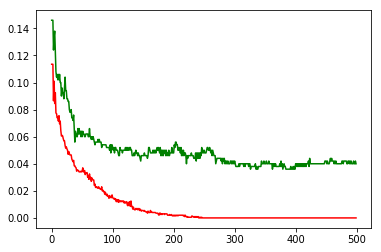

In [10]:
classifier_depth1 = AdaBoost(n_learners=500, base=DecisionTreeClassifier(max_depth=1), random_state=1234)
classifier_depth1.fit(data.X_train, data.y_train)

train_acc1 = classifier_depth1.staged_score(data.X_train, data.y_train)
valid_acc1 = classifier_depth1.staged_score(data.X_valid, data.y_valid)

plt.plot(np.arange(500), 1-train_acc1, color='red')
plt.plot(np.arange(500), 1-valid_acc1, color='green')
plt.show()

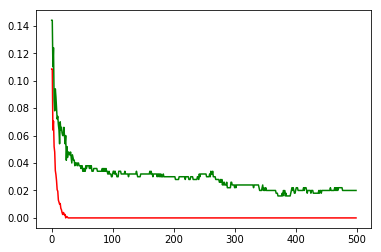

In [11]:
classifier_depth2 = AdaBoost(n_learners=500, base=DecisionTreeClassifier(max_depth=2), random_state=1234)
classifier_depth2.fit(data.X_train, data.y_train)

train_acc2 = classifier_depth2.staged_score(data.X_train, data.y_train)
valid_acc2 = classifier_depth2.staged_score(data.X_valid, data.y_valid)

plt.plot(np.arange(500), 1-train_acc2, color='red')
plt.plot(np.arange(500), 1-valid_acc2, color='green')
plt.show()

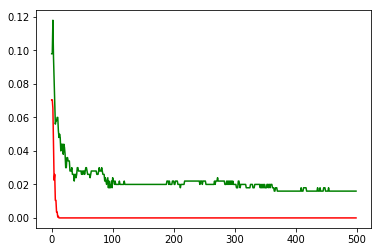

In [12]:
classifier_depth3 = AdaBoost(n_learners=500, base=DecisionTreeClassifier(max_depth=3), random_state=1234)
classifier_depth3.fit(data.X_train, data.y_train)

train_acc3 = classifier_depth3.staged_score(data.X_train, data.y_train)
valid_acc3 = classifier_depth3.staged_score(data.X_valid, data.y_valid)

plt.plot(np.arange(500), 1-train_acc3, color='red')
plt.plot(np.arange(500), 1-valid_acc3, color='green')
plt.show()

In [13]:
print("Iteration where classifiers acheive 100% accuracy:")
print(np.where(train_acc1==1)[0][0])
print(np.where(train_acc2==1)[0][0])
print(np.where(train_acc3==1)[0][0])

Iteration where classifiers acheive 100% accuracy:
241
23
12


**Answer**:

With increase in the decision tree depth/complexity with at lesser number of iterations the training error seem to be decresed. But with increase in complexity the error on the validation set decreases

### [15 points] Problem 4: AdaBoost as a Margin-Maximizing Model 
***

Despite the fact that we're making our model more complex with the addition of each weak learner, AdaBoost does not typically overfit the training data. The reason for this is that the model becomes more _confident_ with each boosting iteration. This _confidence_ can be interpreted mathematically as a margin. Recall that after $K$ iterations the algorithm terminates with the classifier 

$$
H({\bf x}) = \textrm{sign}\left[\displaystyle\sum_{k=1}^K\alpha_k h_k({\bf x}) \right]
$$

Similarly, we can define the intermediate classifier $H_\ell$ by 

$$
H_\ell({\bf x}) = \textrm{sign}\left[\displaystyle\sum_{k=1}^\ell\alpha_k h_k({\bf x}) \right]
$$

where $\ell \leq K$. Note that in either case the model returns predictions of the form $y \in \{-1, 1\}$ which does not give us any indication of the model's confidence in a prediction. Define the normalized coefficients $\hat{\alpha}_k$ as follows: 

$$
\hat{\alpha}_k = \dfrac{\alpha_k}{\sum_{t=1}^K \alpha_k}
$$

Define the margin of a training example ${\bf x}$ after $\ell$ iterations as the sum of the normalized coefficients of weak learners that vote correctly minus the sum of the normalized coefficients of the weak learners that vote incorrectly: 

$$
\textrm{margin}_\ell ({\bf x}) = \sum_{k=1:~h_k({\bf x}) = y}^\ell \hat{\alpha}_k - \sum_{k=1:~h_k({\bf x}) \neq y}^\ell \hat{\alpha}_k 
$$

**Part A**: Briefly explain mathematically how $\textrm{margin}_\ell({\bf x})$ can be interpreted as a margin.  **Hint**: You'll want to think back on what we meant by a _margin_ in our discussion of Support Vector Machines. 

**ANSWER**:

High weighted sum of alphas indicates that the classifier classifies the data easily. So, $\textrm{margin}_\ell({\bf x})$ tells how good/bad a learner is in classifying the training example.

1. $\textrm{margin}_\ell({\bf x})$ >> 0 : Input point was easily classified. Increase in the margin value indicates that the model is becoming more confident in classifying a point. 
2. $\textrm{margin}_\ell({\bf x})$ = 0 : Input point was classified correctly with difficulty
3. $\textrm{margin}_\ell({\bf x})$ < 0 : Input point was classified incorrectly

**Part B**: Complete the `staged_margin` method in the `AdaBoost` class above so that it computes the margin for a single training example ${\bf x}$ after each boosting iteration. 

In [14]:
adaBoost = AdaBoost(n_learners= np.where(train_acc3 == 1)[0][0], base=DecisionTreeClassifier(max_depth=3), random_state=1234)
adaBoost.fit(data.X_train, data.y_train)

print(adaBoost.staged_margin(data.X_train[0], data.y_train[0]))

[0.12507215 0.20532145 0.14068517 0.21756928 0.31192642 0.39007768
 0.47577568 0.38970067 0.45782254 0.522904   0.61495383 0.69857744]


**Part C**: Find four **training** examples from the MNIST that meet the following criteria: 

- one $3$ that AdaBoost can classify easily  
- one $8$ that AdaBoost can classify easily  
- one $3$ that AdaBoost has difficulty with 
- one $8$ that AdaBoost has difficulty with 

Use the `view_digit` function given below to display the four examples that you found. 

**Advice**: Since AdaBoost will likely classify **all** training examples correctly given enough boosting iterations, you might try fitting an AdaBoost classifier with just a handful of boosting iterations and use it to identify examples of each desired type. 

true label: 1


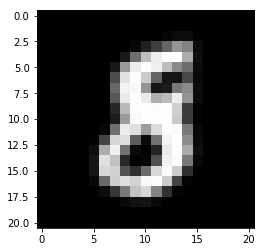

In [15]:
def view_digit(example, label=None):
    if label: print("true label: {:d}".format(label))
    plt.imshow(example.reshape(21,21), cmap='gray');
    
view_digit(data.X_train[0,:], data.y_train[0])

In [16]:
num3_data = []
num8_data = []

for i in range(len(data.X_train)):
    if data.y_train[i] == 1:
        num8_data.append((adaBoost.staged_margin(data.X_train[i], data.y_train[i])[-1], i))
    else:
        num3_data.append((adaBoost.staged_margin(data.X_train[i], data.y_train[i])[-1], i))

In [17]:
num3_data = sorted(num3_data, key=lambda x: x[0])
num8_data = sorted(num8_data, key=lambda x: x[0])

print('easy 3 (margin, index) = ', num3_data[-1])
print('easy 8 (margin, index) = ', num8_data[-1])
print('hard 3 (margin, index) = ', num3_data[0])
print('hard 8 (margin, index) = ', num8_data[0])

easy_3_index = num3_data[-1][1]
easy_8_index = num8_data[-1][1]
hard_3_index = num3_data[0][1]
hard_8_index = num8_data[0][1]

easy 3 (margin, index) =  (1.0, 1984)
easy 8 (margin, index) =  (1.0, 1961)
hard 3 (margin, index) =  (-0.03929803950843552, 455)
hard 8 (margin, index) =  (0.03839852982077119, 1764)


Clear/Easy 3
true label: -1


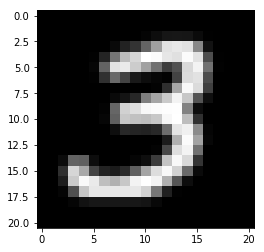

In [18]:
print('Clear/Easy 3')
view_digit(data.X_train[easy_3_index,:], data.y_train[easy_3_index])

Clear/Easy 8
true label: 1


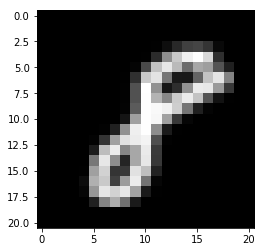

In [19]:
print('Clear/Easy 8')
view_digit(data.X_train[easy_8_index,:], data.y_train[easy_8_index])

Unclear/hard 3
true label: -1


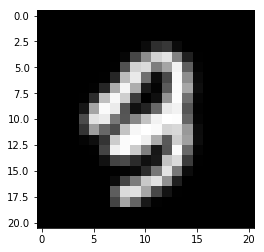

In [20]:
print('Unclear/hard 3')
view_digit(data.X_train[hard_3_index,:], data.y_train[hard_3_index])

Unclear/hard 8
true label: 1


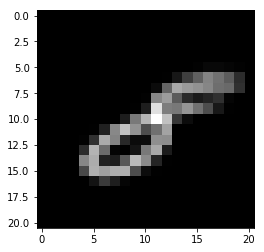

In [21]:
print('Unclear/hard 8')
view_digit(data.X_train[hard_8_index,:], data.y_train[hard_8_index])

**Part D**: Using an AdaBoost classifier with at least $K=200$ depth-1 decision trees as the weak learners, plot the staged margin for each of the four examples that you found in **Part C** on the same set of axes. (Be sure to include a legend so we can tell which staged margin corresponds to which example).  Explain your results in terms of the margin of the classifier on each training examples.  More broadly, how the margin-maximizing property might allow AdaBoost to continue improving generalization even after the error on the training set reaches zero.  


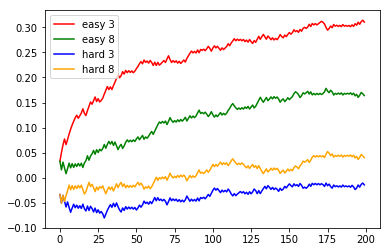

In [22]:
classifier_adaboost = AdaBoost(n_learners=200, base=DecisionTreeClassifier(max_depth=1), random_state=1234)
classifier_adaboost.fit(data.X_train, data.y_train)
easy_3 = classifier_adaboost.staged_margin(data.X_train[easy_3_index], data.y_train[easy_3_index])
easy_8 = classifier_adaboost.staged_margin(data.X_train[easy_8_index], data.y_train[easy_8_index])
hard_3 = classifier_adaboost.staged_margin(data.X_train[hard_3_index], data.y_train[hard_3_index])
hard_8 = classifier_adaboost.staged_margin(data.X_train[hard_8_index], data.y_train[hard_8_index])

plt.plot(np.arange(200), easy_3, color='red', label='easy 3')
plt.plot(np.arange(200), easy_8, color='green', label = 'easy 8')
plt.plot(np.arange(200), hard_3, color='blue', label = 'hard 3')
plt.plot(np.arange(200), hard_8, color='orange', label = 'hard 8')

plt.legend(loc='upper left')

plt.show()

The training examples which were classified easily had the higher margin/confidence and the margin is increased with increase in number of iterations i.e., model is becoming more and more confident with increase in iterations. 